# Plot

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../../Recast/ATLAS-TOPQ-2019-23_tpT')
from atlas_topq_2019_23_Limits import read_ATLASdata, getSMLO, getKfactor

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

colors = sns.color_palette('Paired')

### Load Recast Data

In [2]:
recastDataAll = pd.read_pickle('../../Recast/ATLAS-TOPQ-2019-23_tpT/pp2tt_formFactors_scan_chi2.pcl')
recastDataEFTAll = pd.read_pickle('../../Recast/ATLAS-TOPQ-2019-23_tpT/pp2tt_eft_scan.pcl')

### Get ATLAS data

In [3]:
xsecsObs,smNLO,covMatrix = read_ATLASdata(dataDir='../../Recast/ATLAS-TOPQ-2019-23_tpT/data')
bgError = np.sqrt(covMatrix.diagonal())
atlas_bins = np.array([355.0,381.0,420.0,478.0,549.0,633.0,
                        720.0,836.0,2000.0])
bin_widths  = atlas_bins[1:]-atlas_bins[:-1]  

### Get SM prediction and k-factor

In [4]:
# ### Load SM prediction (LO)
smLO = getSMLO('../../Recast/ATLAS-TOPQ-2019-23_tpT/sm/sm_atlas_topq_2019_23.pcl')
# ### Load k-factors
kfac = getKfactor(smNLO,smLO)
smNLO = smNLO/bin_widths

## Light Point 1

### Select parameters

In [5]:
mST = 500.0
mChi = 400.0
yDM = 1.0

recastData = recastDataAll[(recastDataAll['mST'] == mST) & (recastDataAll['mChi'] == mChi) & (recastDataAll['yDM'] == yDM)]
recastDataEFT = recastDataEFTAll[(recastDataEFTAll['mST'] == mST) & (recastDataEFTAll['mChi'] == mChi) & (recastDataEFTAll['yDM'] == yDM)]
mST,mChi,yDM = recastData[['mST','mChi','yDM']].iloc[0]
print(mST,mChi,yDM)
print(len(recastData),len(recastDataEFT))

500.0 400.0 1.0
1 1


### Get signal

In [6]:
binCols = [c for c in recastData.columns 
               if 'bin_' in c.lower() and not 'error' in c.lower()]
bins_left = np.array([eval(c.split('_')[1]) for c in binCols])
bins_right = np.array([eval(c.split('_')[2]) for c in binCols])     
bin_centers = (bins_left+bins_right)/2.0
bin_widths = bins_right-bins_left
cms_bins = np.append(bins_left,bins_right[-1])

signal = list(zip(bins_left,recastData.iloc[0][binCols].values))
signal = np.array(sorted(signal))[:,1]

signalEFT = list(zip(bins_left,recastDataEFT.iloc[0][binCols].values))
signalEFT = np.array(sorted(signalEFT))[:,1]


### Apply k-factors and rescale by bins

In [7]:
signalNLO = signal*kfac/bin_widths
signalEFTNLO = signalEFT*kfac/bin_widths

### Plot distribution and data

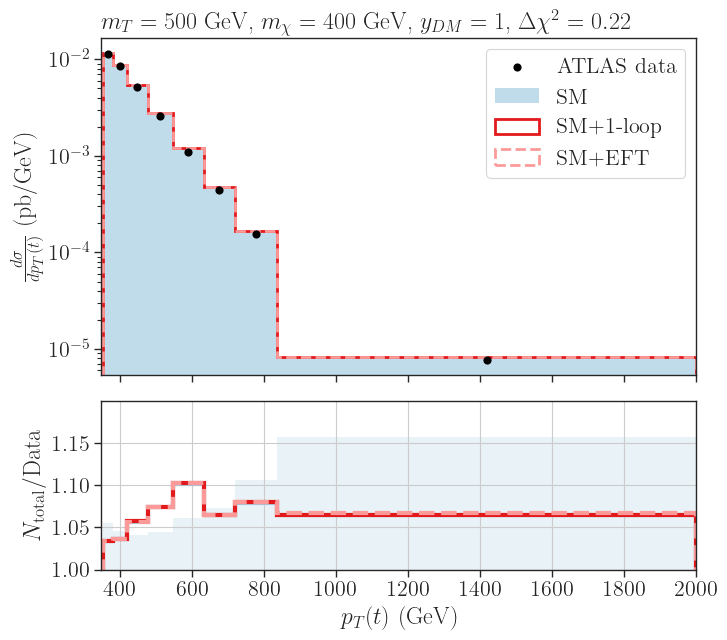

In [10]:
yDM = recastData.iloc[0]['yDM']
deltaChi2 = recastData.iloc[0]['deltaChi2']

_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(7,7))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

axarr[0].scatter(bin_centers,xsecsObs,label='ATLAS data',linewidth=2,s=15,
c='black',zorder=10)
axarr[0].hist(bin_centers,weights=smNLO,label=r'SM',histtype='step',linewidth=0,bins=cms_bins,color=colors[0],fill=True,alpha=0.7)
axarr[0].hist(bin_centers,weights=smNLO+signalNLO*yDM**2,label=r'SM+1-loop',histtype='step',linewidth=2,bins=cms_bins,color=colors[5])
axarr[0].hist(bin_centers,weights=smNLO+signalEFTNLO*yDM**2,label=r'SM+EFT',histtype='step',linewidth=2,bins=cms_bins,linestyle='dashed',color=colors[4])
axarr[0].set_yscale('log')
# axarr[0].set_ylim(1e-6,2e-2)
axarr[0].legend()
axarr[0].set_xlim(350.,2000.)
# axarr[0].grid()

axarr[1].hist(bin_centers,weights=np.divide(smNLO,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[0])
axarr[1].hist(bin_centers,weights=np.divide(smNLO+signalNLO*yDM**2,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[5])
axarr[1].hist(bin_centers,weights=np.divide(smNLO+signalEFTNLO*yDM**2,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[4],linestyle='dashed')

# axarr[1].bar(x=bins_left, height=np.divide(2*bgError,xsecsObs), bottom=np.divide(smNLO-bgError,xsecsObs), width=bin_widths, align='edge', linewidth=0, color=colors[0], alpha=0.25, zorder=-1, label='uncertainty band')

axarr[1].bar(x=bins_left, height=np.divide(2*bgError,xsecsObs), bottom=np.divide(xsecsObs-bgError,xsecsObs), width=bin_widths, align='edge', linewidth=0, color=colors[0], alpha=0.25, zorder=-1, label='uncertainty band')


axarr[1].set_yticks(np.arange(1.0,1.2,0.05))
axarr[1].set_ylim(1.0,1.2)
axarr[1].grid()

axarr[1].set_xlabel(r'$p_T(t)$ (GeV)')
axarr[0].set_ylabel(r'$\frac{d \sigma}{d p_T(t)}$ (pb/GeV)')
axarr[1].set_ylabel(r'$N_{\rm total}/{\rm Data}$')

axarr[0].set_title(r'$m_T = %1.0f$ GeV, $m_{\chi} = %1.0f$ GeV, $y_{DM} = %1.0f$, $\Delta \chi^2 = %1.2f$' %(mST,mChi,yDM,deltaChi2),loc='left')
# plt.savefig('ATLAS_pTt_mST%i_mChi%i_yDM_%i.png' %(int(mST),int(mChi),int(yDM)))
plt.show()

## Light Point 2

### Select parameters

In [ ]:
mST = 700.0
mChi = 600.0
yDM = 1.0

recastData = recastDataAll[(recastDataAll['mST'] == mST) & (recastDataAll['mChi'] == mChi) & (recastDataAll['yDM'] == yDM)]
recastDataEFT = recastDataEFTAll[(recastDataEFTAll['mST'] == mST) & (recastDataEFTAll['mChi'] == mChi) & (recastDataEFTAll['yDM'] == yDM)]
print(len(recastData),len(recastDataEFT))

1 1


### Get signal

In [ ]:
binCols = [c for c in recastData.columns 
               if 'bin_' in c.lower() and not 'error' in c.lower()]
bins_left = np.array([eval(c.split('_')[1]) for c in binCols])
bins_right = np.array([eval(c.split('_')[2]) for c in binCols])     
bin_centers = (bins_left+bins_right)/2.0
bin_widths = bins_right-bins_left
cms_bins = np.append(bins_left,bins_right[-1])

signal = list(zip(bins_left,recastData.iloc[0][binCols].values))
signal = np.array(sorted(signal))[:,1]

signalEFT = list(zip(bins_left,recastDataEFT.iloc[0][binCols].values))
signalEFT = np.array(sorted(signalEFT))[:,1]


### Apply k-factors and rescale by bins

In [ ]:
signalNLO = signal*kfac/bin_widths
signalEFTNLO = signalEFT*kfac/bin_widths

### Plot distribution and data

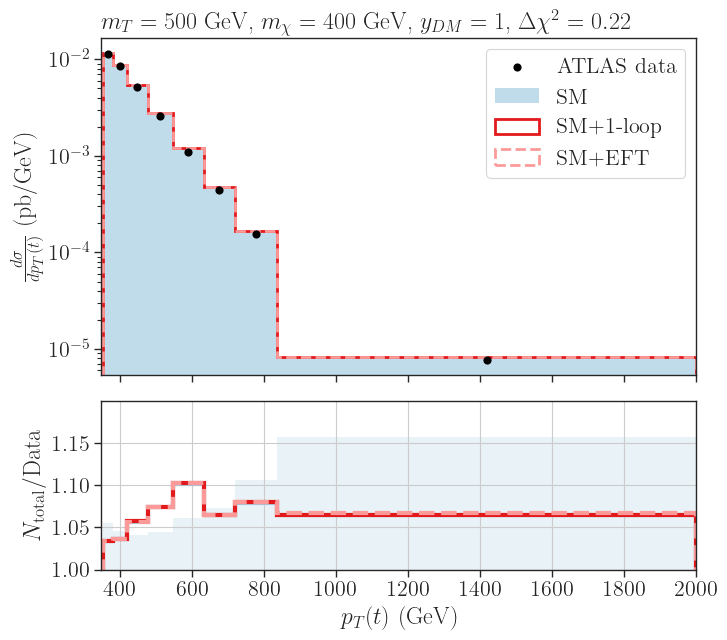

In [11]:
yDM = recastData.iloc[0]['yDM']
deltaChi2 = recastData.iloc[0]['deltaChi2']

_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(7,7))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

axarr[0].scatter(bin_centers,xsecsObs,label='ATLAS data',linewidth=2,s=15,
c='black',zorder=10)
axarr[0].hist(bin_centers,weights=smNLO,label=r'SM',histtype='step',linewidth=0,bins=cms_bins,color=colors[0],fill=True,alpha=0.7)
axarr[0].hist(bin_centers,weights=smNLO+signalNLO*yDM**2,label=r'SM+1-loop',histtype='step',linewidth=2,bins=cms_bins,color=colors[5])
axarr[0].hist(bin_centers,weights=smNLO+signalEFTNLO*yDM**2,label=r'SM+EFT',histtype='step',linewidth=2,bins=cms_bins,linestyle='dashed',color=colors[4])
axarr[0].set_yscale('log')
# axarr[0].set_ylim(1e-6,2e-2)
axarr[0].legend()
axarr[0].set_xlim(350.,2000.)
# axarr[0].grid()

axarr[1].hist(bin_centers,weights=np.divide(smNLO,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[0])
axarr[1].hist(bin_centers,weights=np.divide(smNLO+signalNLO*yDM**2,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[5])
axarr[1].hist(bin_centers,weights=np.divide(smNLO+signalEFTNLO*yDM**2,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[4],linestyle='dashed')

# axarr[1].bar(x=bins_left, height=np.divide(2*bgError,xsecsObs), bottom=np.divide(smNLO-bgError,xsecsObs), width=bin_widths, align='edge', linewidth=0, color=colors[0], alpha=0.25, zorder=-1, label='uncertainty band')

axarr[1].bar(x=bins_left, height=np.divide(2*bgError,xsecsObs), bottom=np.divide(xsecsObs-bgError,xsecsObs), width=bin_widths, align='edge', linewidth=0, color=colors[0], alpha=0.25, zorder=-1, label='uncertainty band')


axarr[1].set_ylim(1.0,1.2)
axarr[1].set_yticks(np.arange(1.0,1.2,0.05))
axarr[1].grid()

axarr[1].set_xlabel(r'$p_T(t)$ (GeV)')
axarr[0].set_ylabel(r'$\frac{d \sigma}{d p_T(t)}$ (pb/GeV)')
axarr[1].set_ylabel(r'$N_{\rm total}/{\rm Data}$')
axarr[0].set_title(r'$m_T = %1.0f$ GeV, $m_{\chi} = %1.0f$ GeV, $y_{DM} = %1.0f$, $\Delta \chi^2 = %1.2f$' %(mST,mChi,yDM,deltaChi2),loc='left')


# plt.savefig('ATLAS_pTt_mST%i_mChi%i_yDM_%i.png' %(int(mST),int(mChi),int(yDM)))
plt.show()

In [ ]:
recastDataAll.columns

Index(['model', 'mST', 'mChi', 'mT', 'yDM', 'process', 'xsec (pb)',
       'MC Events', 'file', 'bin_355_381', 'bin_355_381_Error', 'bin_381_420',
       'bin_381_420_Error', 'bin_420_478', 'bin_420_478_Error', 'bin_478_549',
       'bin_478_549_Error', 'bin_549_633', 'bin_549_633_Error', 'bin_633_720',
       'bin_633_720_Error', 'bin_720_836', 'bin_720_836_Error', 'bin_836_2000',
       'bin_836_2000_Error', 'yDM (95% C.L.)', '$\Delta \chi^2$ (95% C.L.)',
       'yDMexp (95% C.L.)', 'deltaChi2', 'chi2min'],
      dtype='object')

In [ ]:
recastData = recastDataAll[(recastDataAll['mST'] == 500.0) & (recastDataAll['mChi'] == 400.0) & (recastDataAll['yDM'] == 1.0)]
recastData[['model', 'mST', 'mChi', 'mT', 'yDM', 'process', 'xsec (pb)', 'yDM (95% C.L.)', '$\\Delta \\chi^2$ (95% C.L.)',
       'yDMexp (95% C.L.)','deltaChi2', 'chi2min']]

,model,mST,mChi,mT,yDM,process,xsec (pb),yDM (95% C.L.),$\Delta \chi^2$ (95% C.L.),yDMexp (95% C.L.),deltaChi2,chi2min
28,Top-FormFactorsOneLoop-UFO,500.0,400.0,172.5,1.0,$g g \to \bar{t} t$$q q \to \bar{t} t$,-0.000023,4.027946,3.84,7.527669,0.218475,10.139227


In [ ]:
recastData = recastDataAll[(recastDataAll['mST'] == 700.0) & (recastDataAll['mChi'] == 600.0) & (recastDataAll['yDM'] == 1.0)]
recastData[['model', 'mST', 'mChi', 'mT', 'yDM', 'process', 'xsec (pb)', 'yDM (95% C.L.)', '$\\Delta \\chi^2$ (95% C.L.)',
       'yDMexp (95% C.L.)','deltaChi2', 'chi2min']]

,model,mST,mChi,mT,yDM,process,xsec (pb),yDM (95% C.L.),$\Delta \chi^2$ (95% C.L.),yDMexp (95% C.L.),deltaChi2,chi2min
55,Top-FormFactorsOneLoop-UFO,700.0,600.0,172.5,1.0,$g g \to \bar{t} t$$q q \to \bar{t} t$,0.000038,5.394931,3.84,9.198096,0.116857,10.139227
